In [1]:
import pandas as pd
from pandas import Timestamp as tmpstemp
from pandas import Timedelta as tmpdelta
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.layers import Dense, Dropout, LSTM, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from portfolio import Portfolio, Asset
from strategies import LSTM_Strategy

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_20221/4031250555.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-04-27 12:12:30.642697: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
USD = Asset.make_USD()
BTC = Asset('BTC')
#BTC.update_history_from_excahnge(currency = 'USD', date_from = tmpstemp('2020-01-01'), date_to = tmpstemp('2024-03-31'))
ETH = Asset('ETH')
#ETH.update_history_from_excahnge(currency = 'USD', date_from = tmpstemp('2020-01-01'), date_to = tmpstemp('2024-03-31'))
USDT = Asset('USDT')
#USDT.update_history_from_excahnge(currency = 'USD', date_from = tmpstemp('2021-01-01'), date_to = tmpstemp('2024-03-31'))

In [3]:
naive_LSTM = LSTM_Strategy(model_input_length = 15)
date_from = tmpstemp('2022-01-01')
x_train, y_train, train_idx, x_val, y_val, val_idx = naive_LSTM.train_val_split_scale(BTC.history.loc[date_from:])

2024-04-27 12:12:32.946530: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
hidden_size = 50
dropout = 0.2
learning_rate = 0.0005

input_layer = Input(shape=(x_train.shape[1], x_train.shape[2]), name = 'input')

LSTM1 = LSTM(units = 50, activation='tanh', return_sequences=True, name = 'LSTM1' )(input_layer)
LSTM1 = Dropout(dropout)(LSTM1)

LSTM2 = LSTM(units = 50, activation='tanh', return_sequences=True, name = 'LSTM2' )(LSTM1)
LSTM2 = Dropout(dropout)(LSTM2)

LSTM3 = LSTM(units = 50, activation='tanh', name = 'LSTM3' )(LSTM2)
LSTM3 = Dropout(dropout)(LSTM3)
'''
hidden1 = Dense(hidden_size, activation='relu', name='hidden_layer1')(LSTM3)
hidden1 = Dropout(dropout)(hidden1)
'''

# Create output layer
out = Dense(1, activation='linear', name = 'Regression_layer')(LSTM3)
model = Model(inputs=[input_layer], outputs=out)

model.compile(optimizer=Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.metrics.mean_squared_error])
naive_LSTM.model = model
#naive_LSTM.model.summary()

#Set up early stopping monitor
early_stopping = EarlyStopping(monitor='val_mean_squared_error',
                               patience=5,
                               mode = "auto",
                               restore_best_weights=True)

naive_LSTM.model.fit([x_train], y_train, 
          validation_data=([x_val], y_val),
          epochs=20, batch_size=64,
          callbacks=[early_stopping])

2024-04-27 12:12:33.484686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-27 12:12:33.487382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-27 12:12:33.489421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-04-27 12:12:33.933712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-27 12:12:33.935443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-27 12:12:33.936731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - ETA: 0s - loss: 0.0314 - mean_squared_error: 0.0314

2024-04-27 12:12:42.486526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-27 12:12:42.489009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-27 12:12:42.490905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - 10s 354ms/step - loss: 0.0314 - mean_squared_error: 0.0314 - val_loss: 0.0551 - val_mean_squared_error: 0.0551
Epoch 2/20
9/9 [==============================] - 2s 208ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0143 - val_mean_squared_error: 0.0143
Epoch 3/20
9/9 [==============================] - 2s 222ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0346 - val_mean_squared_error: 0.0346
Epoch 4/20
9/9 [==============================] - 1s 156ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 5/20
9/9 [==============================] - 2s 194ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 6/20
9/9 [==============================] - 2s 195ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 7/20
9/9 [==============================] - 

In [62]:
my_portfolio = Portfolio(origination_date=(date_from - tmpdelta(days=1)),
                         initial_deposit= 0.5* BTC.price_on_date(date_from - tmpdelta(days=1)))
my_portfolio.update_transactions(ticker='BTC',
                                qty = 0.5,
                                transaction_date=(date_from - tmpdelta(days=1)),
                                note = 'Initial deposit' )

ref_portfolio = Portfolio(origination_date=(date_from - tmpdelta(days=1)),
                         initial_deposit= 0.5* BTC.price_on_date(date_from - tmpdelta(days=1)))
ref_portfolio.update_transactions(ticker='BTC',
                                qty = 0.5,
                                transaction_date=(date_from - tmpdelta(days=1)),
                                note = 'Initial deposit' )

rebal_portfolio = Portfolio(origination_date=(date_from - tmpdelta(days=1)),
                         initial_deposit= 0.5* BTC.price_on_date(date_from - tmpdelta(days=1)))
rebal_portfolio.update_transactions(ticker='BTC',
                                qty = 0.5,
                                transaction_date=(date_from - tmpdelta(days=1)),
                                note = 'Initial deposit' )

In [6]:
#pred_df = naive_LSTM.predict_batch(data_to_process = BTC.history['close'].loc[val_idx[0]-tmpdelta(days=14):])

In [63]:
def execute_suggestions(suggestions, portfolio):
    for ticker in suggestions.index:
        portfolio.update_transactions(ticker = str(ticker),
                                    qty =  suggestions['change_in_size'].loc[ticker],
                                    transaction_date = today,
                                    note =  suggestions['note'].loc[ticker])

pred_df = pd.DataFrame(data=[],
                        columns = ['Predicted price'],
                        index = pd.DatetimeIndex([], name='date_time'))


def rebalance_make_suggestion(today, portfolio):
    suggestion  = portfolio.get_positions(today).copy()
    total = suggestion['position_value'].sum()
    target_alloc = [0.5, 0.5]
    target_alloc = pd.Series(target_alloc, name = 'target', index = suggestion.index)

    today_price = [Asset.asset_dict[asset].price_on_date(today) for asset in suggestion.index]
    today_price = pd.Series(today_price, name = 'today_price', index = suggestion.index)

    suggestion = pd.concat([suggestion, target_alloc, today_price], axis = 1 )

    suggestion['USD_value'] = suggestion['target']*total - suggestion['position_value']
    suggestion['change_in_size'] = suggestion['USD_value']/suggestion['today_price']

    suggestion['note'] = today.strftime('%Y-%m-%d') + ' rebalancing'
    return suggestion


#Find record in BTC history that is closest to the origin date of the portfolio
first_index = BTC.history.index.get_indexer([my_portfolio.orig_date], method='nearest')[0] + 1
first_date = BTC.history.index[first_index]

alloc = []
for today in BTC.history.index[first_index:-2]:
    tmr = today + tmpdelta(days=1)
    alloc.append(my_portfolio.get_positions(today)['allocation'].loc['BTC'])
    today_data = BTC.history['close'].\
                        loc[today-tmpdelta(days=(naive_LSTM.input_span-1)):today]
    new_pred = naive_LSTM.predict_one(today_data)
    pred_df = pd.concat([pred_df, new_pred], axis = 0)
    suggestion = naive_LSTM.make_suggestion(today, my_portfolio)
    execute_suggestions(suggestion, my_portfolio)

    rebal_suggest = rebalance_make_suggestion(today , rebal_portfolio)
    execute_suggestions(rebal_suggest, rebal_portfolio)


my_portfolio.update_value(up_to=pred_df.index[-1])
ref_portfolio.update_value(up_to=pred_df.index[-1])
rebal_portfolio.update_value(up_to=pred_df.index[-1])

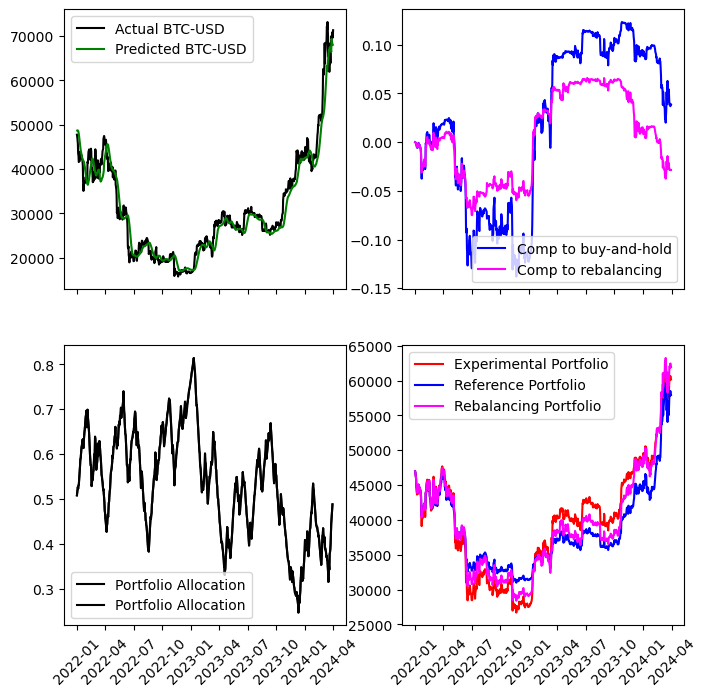

In [67]:
# Plot the results
fig, ax = plt.subplots(2, 2, sharex = True)
fig.set_figheight(8)
fig.set_figwidth(8)
actual_df = BTC.history.loc[first_date:]
ax[0,0].plot(actual_df.index, actual_df['close'], color = 'black', label = 'Actual BTC-USD')
ax[0,0].plot(pred_df.index, pred_df['Predicted price'], color = 'green', label = 'Predicted BTC-USD')
ax[0,0].legend()
for tick in ax[0,0].get_xticklabels():
        tick.set_rotation(45)

ax[0,1].plot(my_portfolio.value.index, (my_portfolio.value['value'] - ref_portfolio.value['value'])/ref_portfolio.value['value'], color = 'blue', label = 'Comp to buy-and-hold')
ax[0,1].plot(my_portfolio.value.index, (my_portfolio.value['value'] - rebal_portfolio.value['value'])/rebal_portfolio.value['value'], color = 'magenta', label = 'Comp to rebalancing')
ax[0,1].legend()
for tick in ax[0,1].get_xticklabels():
        tick.set_rotation(45)

ax[1,0].plot(ref_portfolio.value.index[:-1], alloc, color = 'black', label = 'Portfolio Allocation')
#ax[1,0].plot(rebal_portfolio.value.index[:-1], alloc, color = 'black', label = 'Portfolio Allocation')
ax[1,0].legend()
for tick in ax[1,0].get_xticklabels():
        tick.set_rotation(45)

ax[1,1].plot(my_portfolio.value.index, my_portfolio.value['value'], color = 'red', label = 'Experimental Portfolio')
ax[1,1].plot(ref_portfolio.value.index, ref_portfolio.value['value'], color = 'blue', label = 'Reference Portfolio')
ax[1,1].plot(rebal_portfolio.value.index, rebal_portfolio.value['value'], color = 'magenta', label = 'Rebalancing Portfolio')
ax[1,1].legend()
for tick in ax[1,1].get_xticklabels():
        tick.set_rotation(45)

,position_size,position_value,allocation,target,today_price,USD_value,change_in_size,note
ticker,,,,,,,,
BTC,0.60409,25826.925806,0.551056,0.25,42753.4400,-14109.912631,-0.33003,2022-01-10 rebalancing
ETH,0.5,1620.415,0.034574,0.25,3240.8300,10096.598175,3.115436,2022-01-10 rebalancing
USD,18501.394313,18501.394313,0.394755,0.25,1.0000,-6784.381138,-6784.381138,2022-01-10 rebalancing
USDT,918.95,919.31758,0.019615,0.25,1.0004,10797.695595,10793.378243,2022-01-10 rebalancing
